# RNN Bible Generator

Notebook adapted from the [Shakespeare Text Generation (using RNN LSTM)](https://github.com/trekhleb/machine-learning-experiments/blob/master/experiments/text_generation_shakespeare_rnn/text_generation_shakespeare_rnn.ipynb) notebook.  
Modified by: Gábor Major  
Last Modified date: 2025-03-23

Import libraries.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import platform
import time
import pathlib
import os

print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

Python version: 3.10.6
Tensorflow version: 2.9.1
Keras version: 2.9.0


## Load in Data
The English Revised Version of the Bible was used which was downloaded from [Open Bible](https://openbible.com/texts.htm).  
The Bible downloaded as a TXT file has 31,102 lines of text, with the specific section of the Bible the quote is from at the start of each line.

In [2]:
# Encoding needed to remove \ufeff character
with open('bible.txt', 'r',encoding='utf-8-sig') as f:
    bible_text = f.read()

## Analyse Data

In [3]:
print(f'Length of text: {len(bible_text)} characters')
# Take a look at the first 250 characters in text.
print(bible_text[:250])

Length of text: 217717 characters
Genesis 1:1	In the beginning God created the heaven and the earth.
Genesis 1:2	And the earth was waste and void; and darkness was upon the face of the deep: and the spirit of God moved upon the face of the waters.
Genesis 1:3	And God said, Let there 


In [4]:
# The unique characters in the file
vocabulary = sorted(set(bible_text))

print(f'{len(vocabulary)} unique characters')
print('Vocabularly:', vocabulary)

73 unique characters
Vocabularly: ['\t', '\n', ' ', '!', '(', ')', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'W', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '’']


## Process Data
All of the text must be converted into a sequence of numbers for the model.

In [5]:
# Map characters to their indices in vocabulary.
char2index = {char: index for index, char in enumerate(vocabulary)}

print('{')
for char, _ in zip(char2index, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), char2index[char]))
print('  ...\n}')

{
  '\t':   0,
  '\n':   1,
  ' ' :   2,
  '!' :   3,
  '(' :   4,
  ')' :   5,
  ',' :   6,
  '-' :   7,
  '.' :   8,
  '0' :   9,
  '1' :  10,
  '2' :  11,
  '3' :  12,
  '4' :  13,
  '5' :  14,
  '6' :  15,
  '7' :  16,
  '8' :  17,
  '9' :  18,
  ':' :  19,
  ...
}


In [6]:
# Map character indices to characters from vacabulary.
index2char = np.array(vocabulary)
print(index2char)

['\t' '\n' ' ' '!' '(' ')' ',' '-' '.' '0' '1' '2' '3' '4' '5' '6' '7' '8'
 '9' ':' ';' '?' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N'
 'O' 'P' 'R' 'S' 'T' 'U' 'V' 'W' 'Y' 'Z' 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h'
 'i' 'j' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r' 's' 't' 'u' 'v' 'w' 'x' 'y' 'z'
 '’']


In [7]:
# Convert characters in text to indices.
text_as_int = np.array([char2index[char] for char in bible_text])

print(f'text_as_int length: {len(text_as_int)}')
print(f'{repr(bible_text[:15])} --> {repr(text_as_int[:15])}')

text_as_int length: 217717
'Genesis 1:1\tIn ' --> array([28, 50, 59, 50, 64, 54, 64,  2, 10, 19, 10,  0, 30, 59,  2])


## Create Training Sequences

In [8]:
# The maximum length sentence we want for a single input in characters.
sequence_length = 120
examples_per_epoch = len(bible_text) // (sequence_length + 1)

print('examples_per_epoch:', examples_per_epoch)

examples_per_epoch: 1799


In [9]:
# Create training dataset.
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

for char in char_dataset.take(5):
    print(index2char[char.numpy()])

G
e
n
e
s


In [10]:
# Generate batched sequences out of the char_dataset.
sequences = char_dataset.batch(sequence_length + 1, drop_remainder=True)

# Sequences size is the same as examples_per_epoch.
print(f'Sequences count: {len(list(sequences.as_numpy_iterator()))}');
print()

# Sequences examples.
for item in sequences.take(5):
    print(repr(''.join(index2char[item.numpy()])))

Sequences count: 1799

'Genesis 1:1\tIn the beginning God created the heaven and the earth.\nGenesis 1:2\tAnd the earth was waste and void; and dark'
'ness was upon the face of the deep: and the spirit of God moved upon the face of the waters.\nGenesis 1:3\tAnd God said, Le'
't there be light: and there was light.\nGenesis 1:4\tAnd God saw the light, that it was good: and God divided the light fro'
'm the darkness.\nGenesis 1:5\tAnd God called the light Day, and the darkness he called Night. And there was evening and the'
're was morning, one day.\nGenesis 1:6\tAnd God said, Let there be a firmament in the midst of the waters, and let it divide'


Duplicate and shift each sequence to create the target output.

In [11]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

In [12]:
dataset = sequences.map(split_input_target)

# Dataset size is the same as examples_per_epoch.
# But each element of a sequence is now has length of `sequence_length`
# and not `sequence_length + 1`.
print(f'Dataset size: {len(list(dataset.as_numpy_iterator()))}')

Dataset size: 1799


In [13]:
for input_example, target_example in dataset.take(1):
    print('Input sequence size:', repr(len(input_example.numpy())))
    print('Target sequence size:', repr(len(target_example.numpy())))
    print()
    print('Input:', repr(''.join(index2char[input_example.numpy()])))
    print('Target:', repr(''.join(index2char[target_example.numpy()])))

Input sequence size: 120
Target sequence size: 120

Input: 'Genesis 1:1\tIn the beginning God created the heaven and the earth.\nGenesis 1:2\tAnd the earth was waste and void; and dar'
Target: 'enesis 1:1\tIn the beginning God created the heaven and the earth.\nGenesis 1:2\tAnd the earth was waste and void; and dark'


Model is trained as follows at each step.

In [14]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:5], target_example[:5])):
    print(f'Step {i}')
    print(f'  input: {input_idx} ({index2char[input_idx]})')
    print(f'  expected output: {target_idx} ({index2char[target_idx]})')

Step 0
  input: 28 (G)
  expected output: 50 (e)
Step 1
  input: 50 (e)
  expected output: 59 (n)
Step 2
  input: 59 (n)
  expected output: 50 (e)
Step 3
  input: 50 (e)
  expected output: 64 (s)
Step 4
  input: 64 (s)
  expected output: 54 (i)


## Split into Batches
Split the training sequences into batches, and shuffle them.

In [15]:
# Batch size.
BATCH_SIZE = 64

# Buffer size to shuffle the dataset (TF data is designed to work
# with possibly infinite sequences, so it doesn't attempt to shuffle
# the entire sequence in memory. Instead, it maintains a buffer in
# which it shuffles elements).
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

In [16]:
print(f'Batched dataset size: {len(list(dataset.as_numpy_iterator()))}')

Batched dataset size: 28


In [17]:
for input_text, target_text in dataset.take(1):
    print('1st batch: input_text:', input_text)
    print()
    print('1st batch: target_text:', target_text)

1st batch: input_text: tf.Tensor(
[[12  0 22 ... 48 50 64]
 [50 59  2 ... 53  2 70]
 [49  2 46 ... 28 50 59]
 ...
 [58 46 54 ... 46 53 19]
 [50 59  2 ... 67 50 64]
 [65 60  2 ... 53  2 51]], shape=(64, 120), dtype=int32)

1st batch: target_text: tf.Tensor(
[[ 0 22 59 ... 50 64  8]
 [59  2 60 ...  2 70 60]
 [ 2 46 59 ... 50 59 50]
 ...
 [46 54 49 ... 53 19  2]
 [59  2 65 ... 50 64  2]
 [60  2 61 ...  2 51 60]], shape=(64, 120), dtype=int32)


## Build the Model
Model consits of a Sequential model, with 3 layers.  
Embedding Layer, used for input and as a lookup table.  
LSTM Layer, core of the model, the RNN.  
Dense Layer, used for the output.

In [18]:
# Length of the vocabulary in characters.
vocabulary_size = len(vocabulary)

# The embedding dimension.
embedding_dim = 256

# Number of RNN units.
rnn_units = 1024

In [19]:
def build_model(vocabulary_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Embedding(
        input_dim=vocabulary_size,
        output_dim=embedding_dim,
        batch_input_shape=[batch_size, None]
    ))

    model.add(tf.keras.layers.LSTM(
        units=rnn_units,
        return_sequences=True,
        stateful=True,
        recurrent_initializer=tf.keras.initializers.GlorotNormal()
    ))

    model.add(tf.keras.layers.Dense(vocabulary_size))
  
    return model

In [20]:
model = build_model(vocabulary_size, embedding_dim, rnn_units, BATCH_SIZE)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (64, None, 256)           18688     
                                                                 
 lstm (LSTM)                 (64, None, 1024)          5246976   
                                                                 
 dense (Dense)               (64, None, 73)            74825     
                                                                 
Total params: 5,340,489
Trainable params: 5,340,489
Non-trainable params: 0
_________________________________________________________________


## Train the Model

In [21]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 120, 73) # (batch_size, sequence_length, vocab_size)


In [22]:
# An objective function.
# The function is any callable with the signature scalar_loss = fn(y_true, y_pred).
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(
      y_true=labels,
      y_pred=logits,
      from_logits=True
    )

example_batch_loss = loss(target_example_batch, example_batch_predictions)

print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocabulary_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (64, 120, 73)  # (batch_size, sequence_length, vocabulary_size)
scalar_loss:       4.290621


In [23]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=adam_optimizer,
    loss=loss
)
epochs = 20

In [24]:
# Directory where the checkpoints will be saved.
checkpoint_dir = 'tmp/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_{epoch}')

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True
)

In [25]:
history = model.fit(
  x=dataset,
  epochs=epochs,
  callbacks=[
    checkpoint_callback
  ]
)

Epoch 1/20
28/28 [==============================] - 76s 3s/step - loss: 3.2935
Epoch 2/20
28/28 [==============================] - 118s 4s/step - loss: 2.8404
Epoch 3/20
28/28 [==============================] - 131s 5s/step - loss: 2.2141
Epoch 4/20
28/28 [==============================] - 146s 5s/step - loss: 1.9677
Epoch 5/20
28/28 [==============================] - 148s 5s/step - loss: 1.8347
Epoch 6/20
28/28 [==============================] - 156s 6s/step - loss: 1.7144
Epoch 7/20
28/28 [==============================] - 153s 5s/step - loss: 1.6008
Epoch 8/20
28/28 [==============================] - 167s 6s/step - loss: 1.4996
Epoch 9/20
28/28 [==============================] - 165s 6s/step - loss: 1.4125
Epoch 10/20
28/28 [==============================] - 170s 6s/step - loss: 1.3309
Epoch 11/20
28/28 [==============================] - 172s 6s/step - loss: 1.2686
Epoch 12/20
28/28 [==============================] - 184s 7s/step - loss: 1.2117
Epoch 13/20
28/28 [===================

In [26]:
def render_training_history(training_history):
    loss = training_history.history['loss']
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)
    plt.show()

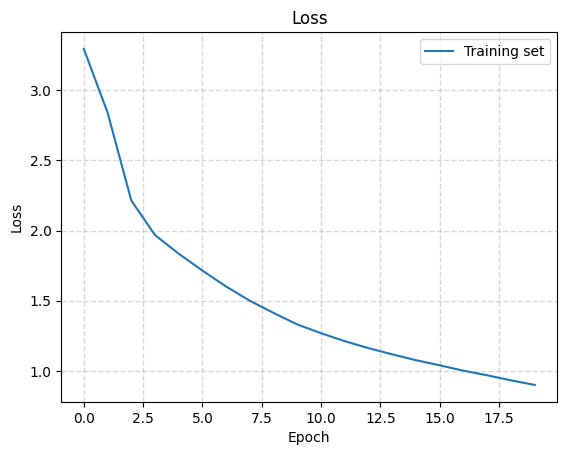

In [27]:
render_training_history(history)

Restore last checkpoint to change batch_size to 1.

In [28]:
tf.train.latest_checkpoint(checkpoint_dir)

'tmp/checkpoints\\ckpt_20'

In [29]:
simplified_batch_size = 1

model = build_model(vocabulary_size, embedding_dim, rnn_units, batch_size=1)
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([simplified_batch_size, None]))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (1, None, 256)            18688     
                                                                 
 lstm_1 (LSTM)               (1, None, 1024)           5246976   
                                                                 
 dense_1 (Dense)             (1, None, 73)             74825     
                                                                 
Total params: 5,340,489
Trainable params: 5,340,489
Non-trainable params: 0
_________________________________________________________________


## Generate Text

In [30]:
# num_generate
# - number of characters to generate.
#
# temperature
# - Low temperatures results in more predictable text.
# - Higher temperatures results in more surprising text.
# - Experiment to find the best setting.
def generate_text(model, start_string, num_generate = 1000, temperature=1.0):
    # Evaluation step (generating text using the learned model)

    # Converting our start string to numbers (vectorizing).
    input_indices = [char2index[s] for s in start_string]
    input_indices = tf.expand_dims(input_indices, 0)

    # Empty string to store our results.
    text_generated = []

    # Here batch size == 1.
    model.reset_states()
    for char_index in range(num_generate):
        predictions = model(input_indices)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # Using a categorical distribution to predict the character returned by the model.
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(
        predictions,
        num_samples=1
        )[-1,0].numpy()

        # We pass the predicted character as the next input to the model
        # along with the previous hidden state.
        input_indices = tf.expand_dims([predicted_id], 0)

        text_generated.append(index2char[predicted_id])

    return (start_string + ''.join(text_generated))

In [31]:
# Generate the text with default temperature (1.0).
print(generate_text(model, start_string=u"Jesus "))

Jesus digngistly in the eyst hath lave I go set.
Genesis 26:9	And it wher shall thlich thy corn, and he gave the remes; and he fenited, and wainged, and said, Let made the servanm And che heaven and her mouth one vening, and begat her houneded an hurdmy.
Genesis 21:37	And Abimelechss begy the people, which he called him nam.
Genesis 30:8	And he said unto him, We was and the gare of the put which the gave in the hendrame that stare upon one alo the flock; but I lift us masce thing that camfling every lift up: ssent in, behold, tell I go an hul bost on house that is time in the land of Canaanith.
Genesis 35:13	And she also and his howe hand there an hundred and said unto Joseph, God made how.
Genesis 7:15	And there anso thou raysel kone say unto him, and shall ye shall be brother out of them, the night, and will I be suith thy brother; These are the doutter of men of his housemoss. now hath begat seem to days in the blest nom to thy lord?
Genesis 30:4	and he unto them; and he had senteng

In [32]:
# Generate the text with lower temperature to get more readable results.
print(generate_text(model, start_string=u"Jesus ", temperature=0.48))

Jesus shall be circumcised; and the children of Seriz were nine hundred and five years: and he said, Let me not see the land of Egypt and came into the land of Egypt and with him into the land of Egypt and said, Behold, I have carned he sent the ground, which were is none unto me, the man of the face of the firstborn against the way of it was donn in his brethren.
Genesis 44:10	And the Amorise, and the God of Jacob her hands in the children of Heth; and he was a righteous borne with me shall be greated unto my day unto thee and the good of the ground; and the seven and said, Who sons of Jacob, and Madar and Zizion, and Sarah his brother unto him the wold, and said, Behold, I have died, and made he death the days of the land of Canaan.
Genesis 24:15	And the famine was sore in the land of Egypt, and the children of Canaan; and the sons of Belaham, the father of the fountain of the breath of the daughter of Egypt were born unto them the tonth, saying, The servant came up from off the eart

## Save Model

In [33]:
model.save('rnn_bible.keras')

## Load Model
The model is then able to be loaded and used.

In [34]:
model = tf.keras.models.load_model('rnn_bible.keras')
print(generate_text(model, start_string=u"Jesus ", temperature=0.7))

Jesus 27:2	And the thing were seven God him for his wife shall be called your with us after their father, saying, The dest of the goods in the day of the land unto the people, of my lord’s bought of the captain of all the earth, and the servant be such an hundred and five your every sur, and hand the flocks of my father’s house, and had not concening unto my lord in the land of Egypt, and and their children of Isreee in the dield.
Genesis 17:2	And Adam kene to the cattle and the days of the servant Joseph was from the king of the gardent of the place, and his faces which he had served between my head, and ars of the land of Egypt.
Genesis 44:13	And he said, What he set me a piven in the land of Egypt said unto them, We are seven death of my kingred and from the flocks upon the earth, and let her forty and with him.
Genesis 27:24	And he said, Who are be carryvint unto Egypt, and said, What came to pass, when the LORD im made a wife of Sarai, and Lot spake unto them.
Genesis 45:13	And he